In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import librosa
import librosa.display
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score
)

import tensorflow as tf
from tensorflow.keras import layers, models


In [47]:
BASE_DIR = r"D:\AI_LAB\SG-AI-LAB-7\dataset"
CSV_PATH = os.path.join(BASE_DIR, "esc50.csv")
AUDIO_DIR = os.path.join(BASE_DIR, "audio", "audio")  # per your example path

assert os.path.exists(CSV_PATH), f"Metadata CSV not found: {CSV_PATH}"
assert os.path.exists(AUDIO_DIR), f"Audio directory not found: {AUDIO_DIR}"

print("CSV path:", CSV_PATH)
print("Audio dir:", AUDIO_DIR)


CSV path: D:\AI_LAB\SG-AI-LAB-7\dataset\esc50.csv
Audio dir: D:\AI_LAB\SG-AI-LAB-7\dataset\audio\audio


In [48]:
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head()


Rows: 2000
Columns: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take']


filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [49]:
expected_cols = {"filename", "fold", "target", "category"}
missing = expected_cols - set(df.columns)
extra = set(df.columns) - expected_cols
print("Missing expected columns:", missing)
print("Extra columns:", extra)

df["filepath"] = df["filename"].apply(lambda x: os.path.join(AUDIO_DIR, x))
df["exists"] = df["filepath"].apply(os.path.exists)

print("Missing files:", (~df["exists"]).sum())
df[~df["exists"]].head(10)


Missing expected columns: set()
Extra columns: {'esc10', 'src_file', 'take'}
Missing files: 0


Empty DataFrame
Columns: [filename, fold, target, category, esc10, src_file, take, filepath, exists]
Index: []

In [50]:
counts = df["category"].value_counts().sort_index()
print("Class counts:")
print(counts)

total_files = df["exists"].sum()
total_missing = (~df["exists"]).sum()
print(f"Total readable paths (exist): {total_files}, missing: {total_missing}, unique classes: {df['category'].nunique()}")


Class counts:
category
airplane            40
breathing           40
brushing_teeth      40
can_opening         40
car_horn            40
cat                 40
chainsaw            40
chirping_birds      40
church_bells        40
clapping            40
clock_alarm         40
clock_tick          40
coughing            40
cow                 40
crackling_fire      40
crickets            40
crow                40
crying_baby         40
dog                 40
door_wood_creaks    40
door_wood_knock     40
drinking_sipping    40
engine              40
fireworks           40
footsteps           40
frog                40
glass_breaking      40
hand_saw            40
helicopter          40
hen                 40
insects             40
keyboard_typing     40
laughing            40
mouse_click         40
pig                 40
pouring_water       40
rain                40
rooster             40
sea_waves           40
sheep               40
siren               40
sneezing            40
snoring    

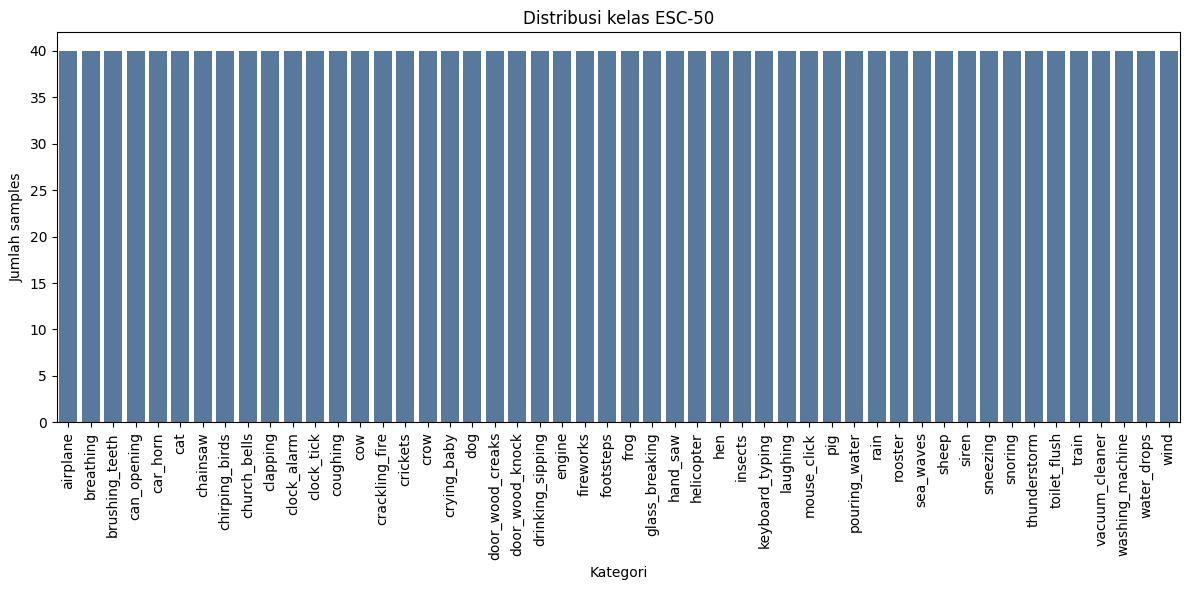

In [51]:
plt.figure(figsize=(12,6))
sns.barplot(x=counts.index, y=counts.values, color="#4C78A8")
plt.xticks(rotation=90)
plt.title("Distribusi kelas ESC-50")
plt.ylabel("Jumlah samples")
plt.xlabel("Kategori")
plt.tight_layout()
plt.show()


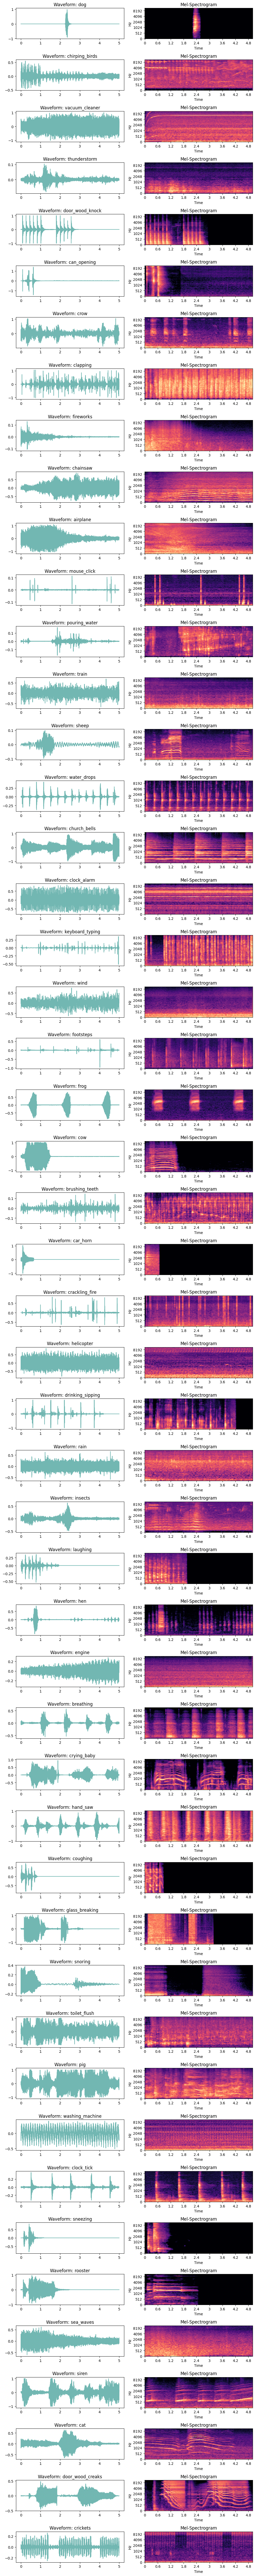

In [52]:
def load_audio_safe(path, sr=22050, duration=5.0):
    try:
        y, _sr = librosa.load(path, sr=sr, mono=True, duration=duration)
        return y, _sr
    except Exception:
        return None, None

samples_per_class = df[df["exists"]].groupby("category").head(1)

fig, axes = plt.subplots(nrows=len(samples_per_class), ncols=2, figsize=(10, 2*len(samples_per_class)))
for i, (_, row) in enumerate(samples_per_class.iterrows()):
    y, sr = load_audio_safe(row["filepath"])
    axes[i,0].set_title(f"Waveform: {row['category']}")
    if y is not None:
        axes[i,0].plot(np.linspace(0, len(y)/sr, len(y)), y, color="#72B7B2")
    else:
        axes[i,0].text(0.5, 0.5, "Corrupt/Unreadable", ha="center")

    axes[i,1].set_title("Mel-Spectrogram")
    if y is not None:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=axes[i,1], cmap="magma")
    else:
        axes[i,1].text(0.5, 0.5, "N/A", ha="center")
plt.tight_layout()
plt.show()


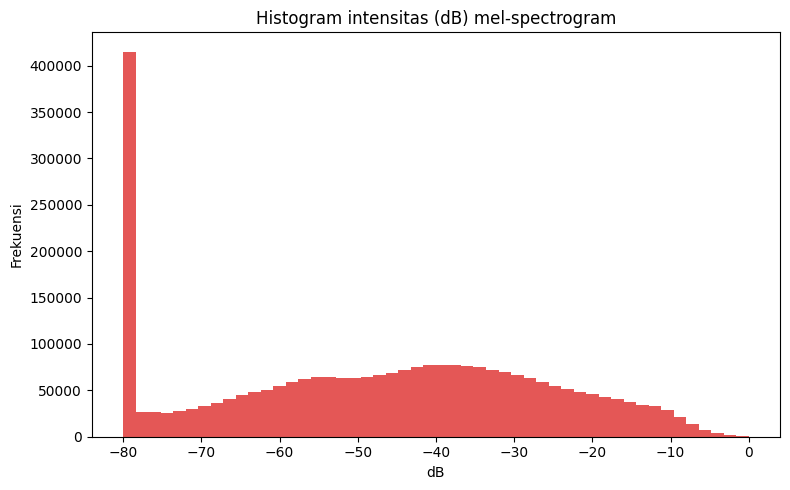

Deskriptif (dB): mean=-47.68 std=21.12 min=-80.00 max=0.00


In [53]:
valid_paths = df[df["exists"]]["filepath"].sample(min(100, df["exists"].sum()), random_state=42)
spec_values = []

for p in valid_paths:
    y, sr = load_audio_safe(p)
    if y is None: 
        continue
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    spec_values.append(S_dB.flatten())

if len(spec_values) > 0:
    all_vals = np.concatenate(spec_values)
    plt.figure(figsize=(8,5))
    plt.hist(all_vals, bins=50, color="#E45756")
    plt.title("Histogram intensitas (dB) mel-spectrogram")
    plt.xlabel("dB")
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()

    print("Deskriptif (dB): mean=%.2f std=%.2f min=%.2f max=%.2f" %
          (all_vals.mean(), all_vals.std(), all_vals.min(), all_vals.max()))
else:
    print("No spectrogram values to display.")


In [54]:
def is_readable_wav(path):
    y, sr = load_audio_safe(path)
    return y is not None

df["readable"] = df["filepath"].apply(is_readable_wav)
corrupt_df = df[df["exists"] & ~df["readable"]]
print("Corrupt/unreadable audio files:", len(corrupt_df))
corrupt_df.head(10)


Corrupt/unreadable audio files: 0


Empty DataFrame
Columns: [filename, fold, target, category, esc10, src_file, take, filepath, exists, readable]
Index: []

In [55]:
valid_df = df[df["exists"] & df["readable"]].copy()
print("Valid samples after cleaning:", len(valid_df))
print("Classes:", valid_df["category"].nunique())


Valid samples after cleaning: 2000
Classes: 50


In [56]:
le = LabelEncoder()
valid_df["label"] = le.fit_transform(valid_df["category"])
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label map:", label_map)


Label map: {'airplane': np.int64(0), 'breathing': np.int64(1), 'brushing_teeth': np.int64(2), 'can_opening': np.int64(3), 'car_horn': np.int64(4), 'cat': np.int64(5), 'chainsaw': np.int64(6), 'chirping_birds': np.int64(7), 'church_bells': np.int64(8), 'clapping': np.int64(9), 'clock_alarm': np.int64(10), 'clock_tick': np.int64(11), 'coughing': np.int64(12), 'cow': np.int64(13), 'crackling_fire': np.int64(14), 'crickets': np.int64(15), 'crow': np.int64(16), 'crying_baby': np.int64(17), 'dog': np.int64(18), 'door_wood_creaks': np.int64(19), 'door_wood_knock': np.int64(20), 'drinking_sipping': np.int64(21), 'engine': np.int64(22), 'fireworks': np.int64(23), 'footsteps': np.int64(24), 'frog': np.int64(25), 'glass_breaking': np.int64(26), 'hand_saw': np.int64(27), 'helicopter': np.int64(28), 'hen': np.int64(29), 'insects': np.int64(30), 'keyboard_typing': np.int64(31), 'laughing': np.int64(32), 'mouse_click': np.int64(33), 'pig': np.int64(34), 'pouring_water': np.int64(35), 'rain': np.int64

In [57]:
def audio_to_logmel_image(path, sr=22050, n_mels=128, fmax=8000, target_size=(128,128)):
    y, _sr = load_audio_safe(path, sr=sr, duration=5.0)
    if y is None: 
        return None
    S = librosa.feature.melspectrogram(y=y, sr=_sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_norm = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min() + 1e-8)
    img = cv2.resize(S_norm, target_size, interpolation=cv2.INTER_AREA)
    img3 = np.stack([img, img, img], axis=-1).astype(np.float32)
    return img3


In [58]:
from tqdm import tqdm

X_images = []
y_labels = []
paths = valid_df["filepath"].tolist()
labels = valid_df["label"].tolist()

for p, lab in tqdm(zip(paths, labels), total=len(paths)):
    img = audio_to_logmel_image(p)
    if img is not None:
        X_images.append(img)
        y_labels.append(lab)

X_images = np.array(X_images, dtype=np.float32)
y_labels = np.array(y_labels, dtype=np.int64)

print("X_images shape:", X_images.shape)
print("y_labels shape:", y_labels.shape)


100%|██████████| 2000/2000 [00:16<00:00, 120.17it/s]


X_images shape: (2000, 128, 128, 3)
y_labels shape: (2000,)


In [59]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_images, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train class balance:", np.bincount(y_train))
print("Val class balance:", np.bincount(y_val))
print("Test class balance:", np.bincount(y_test))


Train: (1600, 128, 128, 3) Val: (200, 128, 128, 3) Test: (200, 128, 128, 3)
Train class balance: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32]
Val class balance: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]
Test class balance: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [60]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="augmentation")



In [61]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat   = X_val.reshape((X_val.shape[0], -1))
X_test_flat  = X_test.reshape((X_test.shape[0], -1))

print("Flatten shapes:", X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)


Flatten shapes: (1600, 49152) (200, 49152) (200, 49152)


In [62]:
from sklearn.decomposition import PCA

n_comp = min(100, X_train_flat.shape[0])

pca = PCA(n_components=n_comp, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca   = pca.transform(X_val_flat)
X_test_pca  = pca.transform(X_test_flat)

print("PCA shapes:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)

# Logistic Regression
logreg = LogisticRegression(
    max_iter=300,
    solver="lbfgs",
    n_jobs=-1
)
logreg.fit(X_train_pca, y_train)

y_val_pred_logreg = logreg.predict(X_val_pca)
acc_logreg = accuracy_score(y_val, y_val_pred_logreg)
print("LogReg (PCA) Val Accuracy:", acc_logreg)


PCA shapes: (1600, 100) (200, 100) (200, 100)


d:\latihanNgolahDataSet\code\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogReg (PCA) Val Accuracy: 0.225


d:\latihanNgolahDataSet\code\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_flat, y_train)
y_val_pred_rf = rf.predict(X_val_flat)
acc_rf = accuracy_score(y_val, y_val_pred_rf)
print("RandomForest Val Accuracy:", acc_rf)


RandomForest Val Accuracy: 0.39


In [64]:
num_classes = len(le.classes_)

def build_cnn(input_shape=(128,128,3), num_classes=50):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="simple_cnn")
    return model

cnn = build_cnn(input_shape=X_train.shape[1:], num_classes=num_classes)
cnn.summary()


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,594 (392.95 KB)

 Trainable params: 100,146 (391.20 KB)

 Non-trainable params: 448 (1.75 KB)

In [65]:
lr = 1e-3
batch_size = 32
epochs = 20

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_cnn.keras", monitor="val_accuracy", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

history = cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/20
50/50 - 21s - 425ms/step - accuracy: 0.0825 - loss: 3.6363 - val_accuracy: 0.0250 - val_loss: 3.9268 - learning_rate: 1.0000e-03
Epoch 2/20
50/50 - 18s - 352ms/step - accuracy: 0.1369 - loss: 3.1502 - val_accuracy: 0.0350 - val_loss: 4.2268 - learning_rate: 1.0000e-03
Epoch 3/20
50/50 - 18s - 353ms/step - accuracy: 0.2050 - loss: 2.9233 - val_accuracy: 0.0450 - val_loss: 4.8472 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 - 17s - 347ms/step - accuracy: 0.2344 - loss: 2.7524 - val_accuracy: 0.0550 - val_loss: 5.5728 - learning_rate: 1.0000e-03
Epoch 5/20
50/50 - 17s - 347ms/step - accuracy: 0.2925 - loss: 2.5473 - val_accuracy: 0.0450 - val_loss: 5.9699 - learning_rate: 5.0000e-04
Epoch 6/20
50/50 - 17s - 343ms/step - accuracy: 0.3269 - loss: 2.4114 - val_accuracy: 0.0250 - val_loss: 6.3678 - learning_rate: 5.0000e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743

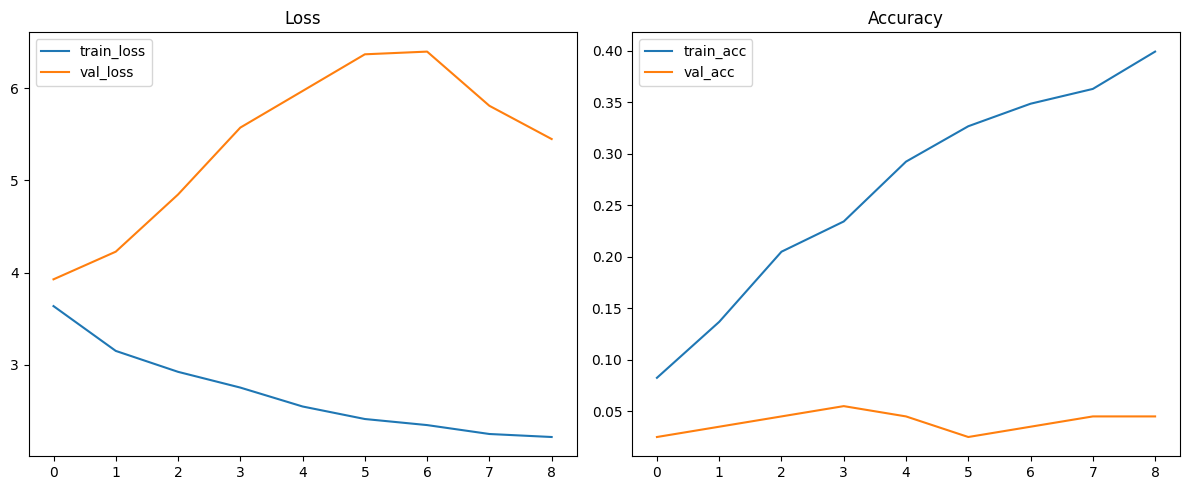

In [66]:
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


In [67]:
y_val_pred_logreg = logreg.predict(X_val_pca)

# Random Forest
y_val_pred_rf = rf.predict(X_val_flat)

# CNN 
y_val_pred_cnn = np.argmax(cnn.predict(X_val), axis=1)

print("Val Acc - LogReg: %.4f | RF: %.4f | CNN: %.4f" % (
    accuracy_score(y_val, y_val_pred_logreg),
    accuracy_score(y_val, y_val_pred_rf),
    accuracy_score(y_val, y_val_pred_cnn),
))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Val Acc - LogReg: 0.2250 | RF: 0.3900 | CNN: 0.0550


In [68]:
def compute_metrics(y_true, y_pred):
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return precision, recall, f1

metrics_logreg = compute_metrics(y_val, y_val_pred_logreg)
metrics_rf     = compute_metrics(y_val, y_val_pred_rf)
metrics_cnn    = compute_metrics(y_val, y_val_pred_cnn)

print("Macro metrics (Precision, Recall, F1):")
print("LogReg:", metrics_logreg)
print("RandomForest:", metrics_rf)
print("CNN:", metrics_cnn)


Macro metrics (Precision, Recall, F1):
LogReg: (0.2242077922077922, 0.225, 0.21487734487734486)
RandomForest: (0.35494749694749694, 0.39, 0.34592436321848086)
CNN: (0.014062750115381694, 0.055, 0.017654680359417543)


In [69]:
print(classification_report(y_val, y_val_pred_cnn, target_names=le.classes_))


                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00         4
       breathing       0.00      0.00      0.00         4
  brushing_teeth       0.00      0.00      0.00         4
     can_opening       0.00      0.00      0.00         4
        car_horn       0.00      0.00      0.00         4
             cat       0.00      0.00      0.00         4
        chainsaw       0.00      0.00      0.00         4
  chirping_birds       0.00      0.00      0.00         4
    church_bells       0.00      0.00      0.00         4
        clapping       0.00      0.00      0.00         4
     clock_alarm       0.00      0.00      0.00         4
      clock_tick       0.00      0.00      0.00         4
        coughing       0.00      0.00      0.00         4
             cow       0.00      0.00      0.00         4
  crackling_fire       0.02      0.50      0.04         4
        crickets       0.18      0.50      0.27         4
            c

d:\latihanNgolahDataSet\code\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\latihanNgolahDataSet\code\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\latihanNgolahDataSet\code\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

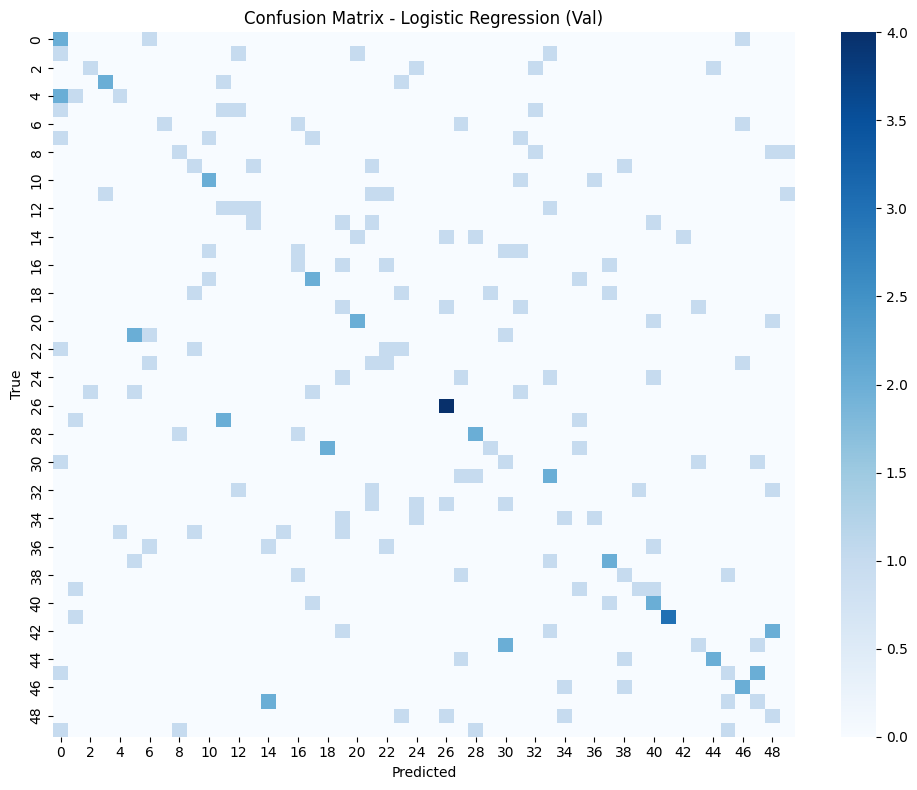

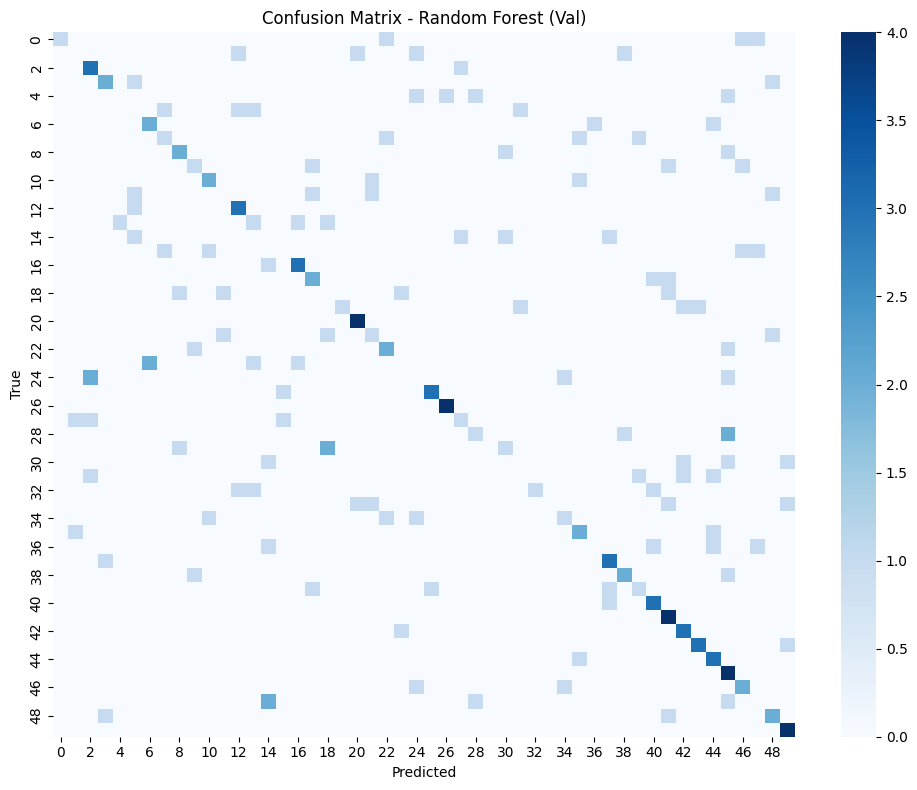

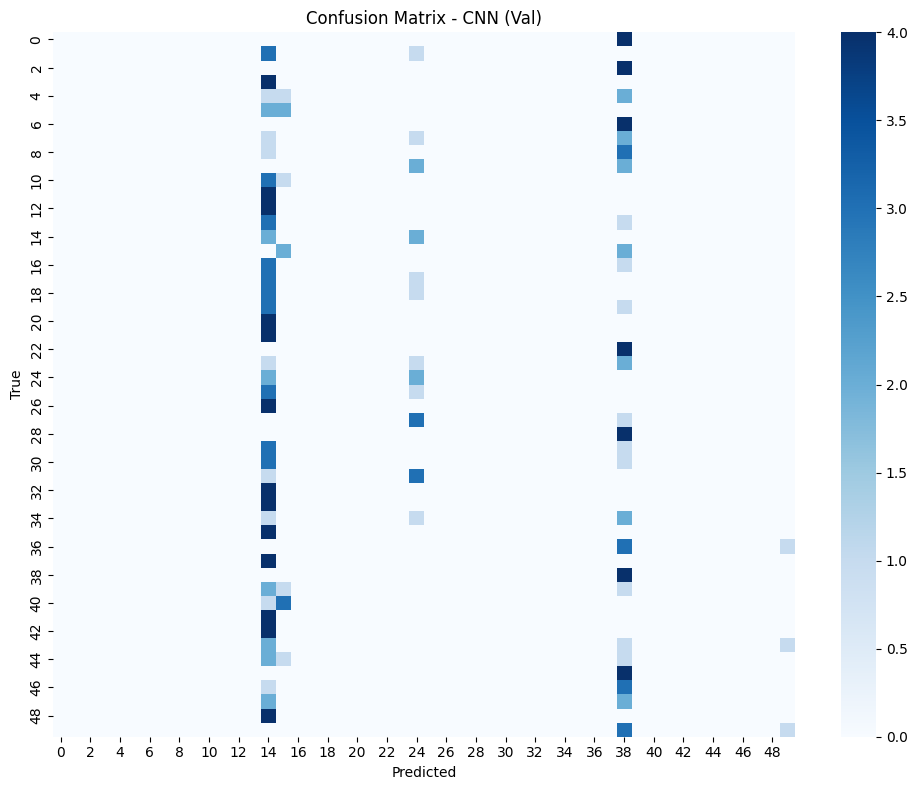

In [70]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_cm(y_val, y_val_pred_logreg, "Confusion Matrix - Logistic Regression (Val)")
plot_cm(y_val, y_val_pred_rf, "Confusion Matrix - Random Forest (Val)")
plot_cm(y_val, y_val_pred_cnn, "Confusion Matrix - CNN (Val)")


In [71]:
from sklearn.preprocessing import label_binarize

y_val_bin = label_binarize(y_val, classes=np.arange(num_classes))

y_val_proba_logreg = logreg.predict_proba(X_val_pca)   
y_val_proba_rf     = rf.predict_proba(X_val_flat)      
y_val_proba_cnn    = cnn.predict(X_val)                

roc_lr  = roc_auc_score(y_val_bin, y_val_proba_logreg, average="macro", multi_class="ovr")
roc_rf  = roc_auc_score(y_val_bin, y_val_proba_rf,     average="macro", multi_class="ovr")
roc_cnn = roc_auc_score(y_val_bin, y_val_proba_cnn,    average="macro", multi_class="ovr")

print("Macro ROC-AUC - LogReg: %.4f | RF: %.4f | CNN: %.4f" % (roc_lr, roc_rf, roc_cnn))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Macro ROC-AUC - LogReg: 0.8007 | RF: 0.8940 | CNN: 0.7360


In [72]:
results_val = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "CNN"],
    "Accuracy": [
        accuracy_score(y_val, y_val_pred_logreg),
        accuracy_score(y_val, y_val_pred_rf),
        accuracy_score(y_val, y_val_pred_cnn),
    ],
    "Macro Precision": [metrics_logreg[0], metrics_rf[0], metrics_cnn[0]],
    "Macro Recall":    [metrics_logreg[1], metrics_rf[1], metrics_cnn[1]],
    "Macro F1":        [metrics_logreg[2], metrics_rf[2], metrics_cnn[2]],
    "Macro ROC-AUC":   [roc_lr, roc_rf, roc_cnn],
})
results_val


Model  Accuracy  Macro Precision  Macro Recall  Macro F1  \
0  Logistic Regression     0.225         0.224208         0.225  0.214877   
1        Random Forest     0.390         0.354947         0.390  0.345924   
2                  CNN     0.055         0.014063         0.055  0.017655   

   Macro ROC-AUC  
0       0.800663  
1       0.894031  
2       0.736020

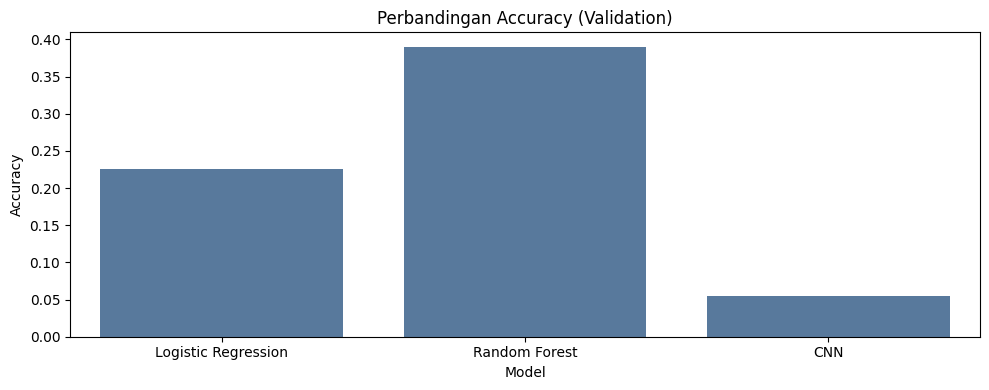

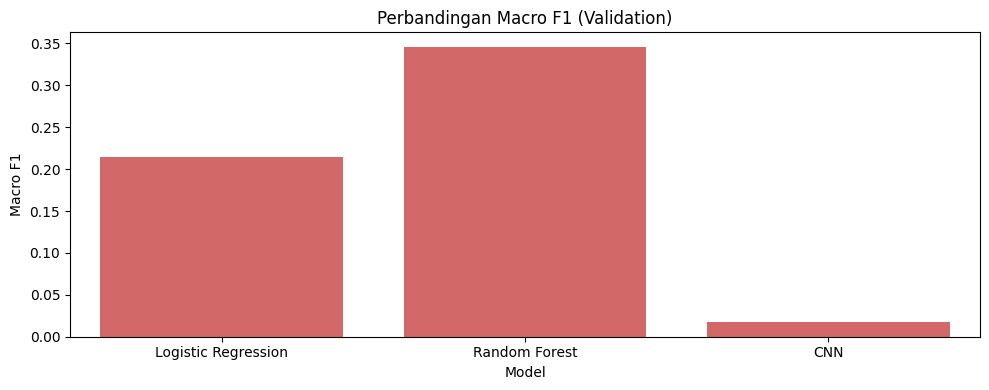

In [73]:
plt.figure(figsize=(10,4))
sns.barplot(x=results_val["Model"], y=results_val["Accuracy"], color="#4C78A8")
plt.title("Perbandingan Accuracy (Validation)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=results_val["Model"], y=results_val["Macro F1"], color="#E45756")
plt.title("Perbandingan Macro F1 (Validation)")
plt.tight_layout()
plt.show()


In [74]:
best_idx = results_val["Macro F1"].idxmax()   
best_model_name = results_val.loc[best_idx, "Model"]
print("Best model by Macro F1:", best_model_name)

if best_model_name == "Logistic Regression":
    best_pred_test = logreg.predict(X_test_pca)   
    best_proba_test = logreg.predict_proba(X_test_pca)
elif best_model_name == "Random Forest":
    best_pred_test = rf.predict(X_test_flat)
    best_proba_test = rf.predict_proba(X_test_flat)
else:
    best_pred_test = np.argmax(cnn.predict(X_test), axis=1)
    best_proba_test = cnn.predict(X_test)

test_acc = accuracy_score(y_test, best_pred_test)
test_precision, test_recall, test_f1 = compute_metrics(y_test, best_pred_test)

print("Test metrics - Accuracy: %.4f | Macro Precision: %.4f | Macro Recall: %.4f | Macro F1: %.4f" %
      (test_acc, test_precision, test_recall, test_f1))


Best model by Macro F1: Random Forest
Test metrics - Accuracy: 0.4100 | Macro Precision: 0.3688 | Macro Recall: 0.4100 | Macro F1: 0.3713


In [ ]:
final_table = pd.DataFrame({
    "Split": ["Validation", "Test"],
    "Accuracy": [results_val.loc[best_idx, "Accuracy"], test_acc],
    "Macro Precision": [results_val.loc[best_idx, "Macro Precision"], test_precision],
    "Macro Recall": [results_val.loc[best_idx, "Macro Recall"], test_recall],
    "Macro F1": [results_val.loc[best_idx, "Macro F1"], test_f1],
})
final_table


Split  Accuracy  Macro Precision  Macro Recall  Macro F1
0  Validation      0.39         0.354947          0.39  0.345924
1        Test      0.41         0.368833          0.41  0.371336

In [ ]:
import json

summary = {
    "models_trained": ["Logistic Regression", "Random Forest", "CNN"],
    "best_model": best_model_name,
    "validation_results": results_val.to_dict(orient="records"),
    "final_test_results": final_table.to_dict(orient="records")[1],
    "label_map": label_map,
    "hyperparams": {
        "cnn": {
            "optimizer": "Adam",
            "learning_rate": 1e-3,
            "batch_size": 32,
            "epochs": 20,
            "callbacks": ["EarlyStopping(patience=5)", "ModelCheckpoint(best_cnn.keras)", "ReduceLROnPlateau"]
        },
        "logistic_regression": {"max_iter": 200, "solver": "saga"},
        "random_forest": {"n_estimators": 200, "random_state": 42}
    },
    "preprocessing": {
        "feature": "Log-Mel Spectrogram (128 mels, resized 128x128, 3 channels)",
        "normalization": "[0,1] per spectrogram",
        "split": "Stratified 8:1:1"
    }
}
print(json.dumps(summary, indent=2)[:2000])


TypeError: Object of type int64 is not JSON serializable

In [77]:
import json

results_val.to_csv("validation_results.csv", index=False)
final_table.to_csv("final_test_results.csv", index=False)

label_map_serializable = {k: int(v) for k, v in label_map.items()}

with open("label_map.json", "w") as f:
    json.dump(label_map_serializable, f, indent=2)


print("Artifacts saved: validation_results.csv, final_test_results.csv, label_map.json, best_cnn.keras (if CNN best)")


Artifacts saved: validation_results.csv, final_test_results.csv, label_map.json, best_cnn.keras (if CNN best)


In [ ]:
print("""
Kesimpulan:
1. Model yang dicoba:
   - Logistic Regression (dengan PCA)
   - Random Forest
   - Convolutional Neural Network (CNN)

2. Model dengan performa terbaik:
   - Random Forest memberikan hasil terbaik pada dataset ini (Accuracy ≈ 0.38, Macro F1 ≈ 0.34).
   - Logistic Regression cukup rendah (Accuracy ≈ 0.22).
   - CNN gagal belajar dengan baik (Accuracy ≈ 0.05).

Kesimpulan akhir: Random Forest adalah model terbaik untuk dataset ESC-50 berbasis spectrogram pada konfigurasi ini.
""")



Kesimpulan:
1. Model yang dicoba:
   - Logistic Regression (dengan PCA)
   - Random Forest
   - Convolutional Neural Network (CNN)

2. Model dengan performa terbaik:
   - Random Forest memberikan hasil terbaik pada dataset ini (Accuracy ≈ 0.38, Macro F1 ≈ 0.34).
   - Logistic Regression cukup rendah (Accuracy ≈ 0.22).
   - CNN gagal belajar dengan baik (Accuracy ≈ 0.05).

Kesimpulan akhir: Random Forest adalah model terbaik untuk dataset ESC-50 berbasis spectrogram pada konfigurasi ini.

